In [1]:
import pandas as pd
import numpy as np
import matplotlib as mp
import seaborn as sns
import re
import os

In [473]:
groups = ['Control','1_group','2_group','3_group','4_group','blank']
times = ['None','0_h','4_h','8_h','20_h','24_h','28_h','32_h','44_h','48_h']

labels_groups= [['B2','C2','D2','E2','F2','G2'],
['B3','B4','B5','B6','B7','B8','B9','B10','B11'],
['C3','C4','C5','C6','C7','C8','C9','C10','C11'],
['D3','D4','D5','D6','D7','D8','D9','D10','D11'],
['E3','E4','E5','E6','E7','E8','E9','E10','E11'],
['F3','G3']]


labels_times = [['B2','C2','D2','E2','F2','G2','F3','G3'],
['B3', 'C3', 'D3', 'E3'],
['B4', 'C4', 'D4', 'E4'],
['B5', 'C5', 'D5', 'E5'],
['B6', 'C6', 'D6', 'E6'],
['B7', 'C7', 'D7', 'E7'],
['B8', 'C8', 'D8', 'E8'],
['B9', 'C9', 'D9', 'E9'],
['B10', 'C10', 'D10', 'E10'],
['B11', 'C11', 'D11', 'E11']]


def image_name_to_label(image_path):
    image_name = os.path.basename(image_path)
    image_name_str = str(image_name)
    well_name_re = re.search(r'([B-G]\d{1,2})',image_name_str)

    return well_name_re[0]

def image_label_to_group(well_label):
    for i,group in enumerate(labels_groups):
        for y,value in enumerate(group):
            if well_label in value:
                index_g = i
                
    group_label = groups[index_g]

    return(group_label)

def image_label_to_time(well_label):
    for i,group in enumerate(labels_times):
        for y,value in enumerate(group):
            if well_label in value:
                index_t = i

    time_label = times[index_t]

    return(time_label)

                
    


In [434]:
path_nuclei = "C:/Users/Modern/Desktop/Kirill/Counted_2/MyExpt_Nucleus_filtered.csv"
path_focii = "C:/Users/Modern/Desktop/Kirill/Counted_2/MyExpt_H2AX_in_nucleus.csv"
path_focii_desc = "C:/Users/Modern/Desktop/Kirill/Counted_2/MyExpt_Masked_H2AX.csv"
path_image_data = "C:/Users/Modern/Desktop/Kirill/Counted_2/MyExpt_Image.csv"



In [435]:
nuclei_pd=pd.read_csv(path_nuclei)
focii_pd=pd.read_csv(path_focii)
focii_desc_pd = pd.read_csv(path_focii_desc)
image_data_pd=pd.read_csv(path_image_data)



In [494]:
labels_nuclei = nuclei_pd.head()
labels_focii = focii_pd.head()
labels_image_data = image_data_pd.head()
labels_path_focii_desc = focii_desc_pd.head()

print(labels_path_focii_desc)

   ImageNumber  ObjectNumber  Children_H2AX_in_nucleus_Count  \
0            2             1                               1   
1            2             2                               1   
2            2             3                               1   
3            2             4                               1   
4            2             5                               1   

   Location_Center_X  Location_Center_Y  Number_Object_Number  Parent_H2AX  \
0         265.125000         237.875000                     1           49   
1         268.285714         247.000000                     2           51   
2         300.550000         252.800000                     3           52   
3         320.846154         254.076923                     4           53   
4         314.600000         256.200000                     5           55   

   Parent_Nucleus_filtered  
0                        1  
1                        1  
2                        1  
3                        1  
4

In [493]:
labels = image_data_pd['URL_Dapi'].apply(image_name_to_label)

labels_df = pd.DataFrame(labels)

well_group = labels_df['URL_Dapi'].apply(image_label_to_group)
well_time = labels_df['URL_Dapi'].apply(image_label_to_time)

labels_df["Group"] = well_group
labels_df["Time"] = well_time


labels_df = labels_df.join(image_data_pd['ImageNumber'])
labels_df = labels_df.rename(columns={'URL_Dapi':'Well_Name'})

# print(labels_df)

In [498]:
foci_image_corr = focii_desc_pd[['ImageNumber','ObjectNumber','Parent_Nucleus_filtered']].copy()
foci_data = focii_pd[['ImageNumber','ObjectNumber','Intensity_IntegratedIntensity_Red']].copy()

foci_data_image_corr = pd.merge(foci_image_corr,foci_data, how='left',
                                left_on=['ImageNumber','ObjectNumber'],right_on=['ImageNumber','ObjectNumber'])

foci_integrated_intensity_summs = foci_data_image_corr.groupby(['Group','Time'])['Intensity_IntegratedIntensity_Red'].sum()

print(foci_data_image_corr)

        ImageNumber  ObjectNumber  Parent_Nucleus_filtered  \
0                 2             1                        1   
1                 2             2                        1   
2                 2             3                        1   
3                 2             4                        1   
4                 2             5                        1   
...             ...           ...                      ...   
579358         4483           145                        4   
579359         4483           146                        4   
579360         4483           147                        4   
579361         4483           148                        4   
579362         4483           149                        4   

        Intensity_IntegratedIntensity_Red  
0                                0.771740  
1                                0.659922  
2                                2.058869  
3                                1.204608  
4                                0.

In [492]:
# print(foci_intensity_sums_df)

focii_data_w_labels = pd.merge(foci_intensity_sums_df,labels_df,left_on=['ImageNumber','Parent_Nucleus_filtered'],right_on = ['ImageNumber','Parent_Nucleus_filtered'])
print(focii_data_w_labels)


KeyError: 'Parent_Nucleus_filtered'

In [426]:
# rslt_df = nuclei_pd[(nuclei_pd['Group'] == "Control" ) & (nuclei_pd['Time'] == "None"   ) |
#                         (nuclei_pd['Group'] == '4_group' ) & (nuclei_pd['Time'] == "4_h")]

# rslt_df = nuclei_pd[(nuclei_pd['Time'] == "None") |(nuclei_pd['Time'] == "48_h")]
rslt_df = nuclei_pd[(nuclei_pd['Group'] == "1_group")]

# column_sum_1 = nuclei_pd.loc[(nuclei_pd['Group']=="Control") & (nuclei_pd['Time'] == "None"),'Children_Masked_H2AX_Count'].mean()
# column_sum_2 = nuclei_pd.loc[(nuclei_pd['Group'] == '4_group' ) & (nuclei_pd['Time'] == "4_h"),'Children_Masked_H2AX_Count'].mean()

# column_std_2 = nuclei_pd.loc[(nuclei_pd['Group'] == '4_group' ) & (nuclei_pd['Time'] == "4_h"),'Children_Masked_H2AX_Count'].std()

# print(column_sum_2)

means = nuclei_pd['Children_Masked_H2AX_Count'].groupby(nuclei_pd['Time']).mean()
print(means)

Time
0_h     38.278908
20_h    39.637950
24_h    36.677957
28_h    36.313223
32_h    39.358521
44_h    44.163955
48_h    32.703681
4_h     36.806985
8_h     35.336316
None     9.296482
Name: Children_Masked_H2AX_Count, dtype: float64


[Text(0.5, 0, 'Number per nucleus'), Text(0, 0.5, 'Relative count')]

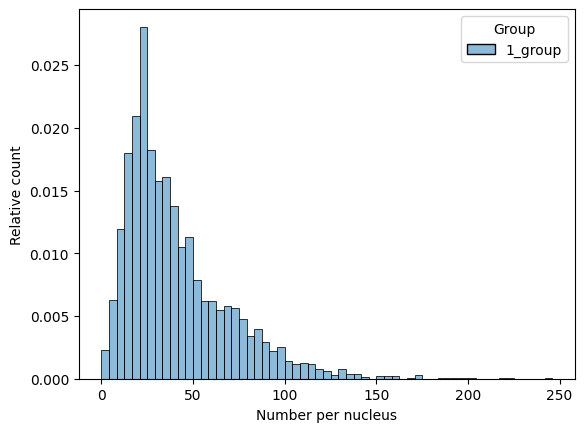

In [427]:
# stat='density' make normilized hystogramm

ax = sns.histplot(data=rslt_df, x=rslt_df['Children_Masked_H2AX_Count'],hue='Group',stat='density')
ax.set(xlabel='Number per nucleus', ylabel='Relative count')


[Text(0.5, 0, 'Foci per nucleus'), Text(0, 0.5, 'Nucleus area')]

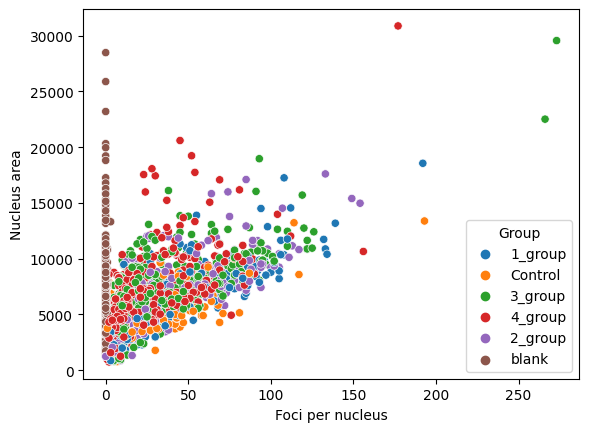

In [313]:
ax = sns.scatterplot(data=rslt_df, x = rslt_df['Children_Masked_H2AX_Count'], y = rslt_df['AreaShape_Area'],hue='Group' )
ax.set(xlabel='Foci per nucleus', ylabel='Nucleus area')

[Text(0.5, 0, 'Foci per nucleus'), Text(0, 0.5, 'Nucleus area')]

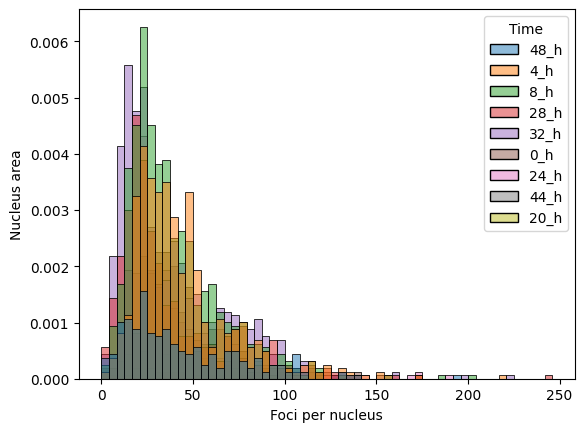

In [428]:
rslt_df = nuclei_pd[(nuclei_pd['Group'] == "1_group")]
ax = sns.histplot(data=rslt_df, x=rslt_df['Children_Masked_H2AX_Count'],hue='Time',stat='density')
ax.set(xlabel='Foci per nucleus', ylabel='Nucleus area')

In [429]:
means = nuclei_pd.groupby(['Group','Time'])['Children_Masked_H2AX_Count'].mean()
means_pd = pd.DataFrame(means)
# means_pd['Time'] =pd.Categorical(means_pd['Time'], categories = times, ordered = True )
print(means_pd)

              Children_Masked_H2AX_Count
Group   Time                            
1_group 0_h                    42.236769
        20_h                   57.833333
        24_h                   41.200000
        28_h                   37.967742
        32_h                   38.184350
        44_h                   48.231481
        48_h                   44.184211
        4_h                    44.556604
        8_h                    39.215365
2_group 0_h                    37.250000
        20_h                   42.286136
        24_h                   36.446581
        28_h                   36.156448
        32_h                   46.134921
        44_h                   49.684492
        48_h                   36.305389
        4_h                    33.619798
        8_h                    35.933333
3_group 0_h                    36.837790
        20_h                   38.462151
        24_h                   36.863727
        28_h                   39.002500
        32_h    